In [12]:
import os, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import joblib

ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
data_path = os.path.join('..', 'data', 'Titanic-Dataset.csv')
if not os.path.exists(data_path):
    alt = '/mnt/data/Titanic-Dataset.csv'
    if os.path.exists(alt):
        data_path = alt
    else:
        raise FileNotFoundError("Place dataset.csv in data/ or ensure uploaded file path exists.")

df = pd.read_csv(data_path)
df.shape


(891, 12)

In [13]:
df.head()
df.info()
df.isnull().sum()
df.describe(include='all')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


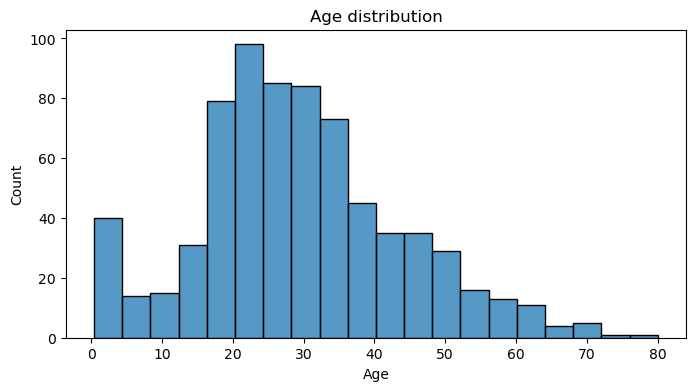

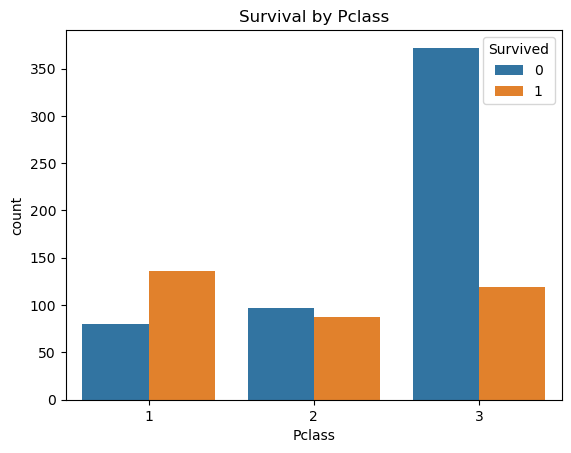

In [14]:
# Age distribution
plt.figure(figsize=(8,4))
sns.histplot(df['Age'].dropna(), kde=False)
plt.title("Age distribution")
plt.show()

# Survival by Pclass
sns.countplot(data=df, x='Pclass', hue='Survived')
plt.title("Survival by Pclass")
plt.show()


In [16]:
features = ['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']
target = 'Survived'
df = df[features + [target]].copy()
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

numeric_features = ['Age','SibSp','Parch','Fare']
numeric_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])

categorical_features = ['Pclass','Sex','Embarked']
categorical_transformer = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer([('num', numeric_transformer, numeric_features), ('cat', categorical_transformer, categorical_features)])

pipelines = {
    'logistic': Pipeline([('preproc', preprocessor), ('clf', LogisticRegression(max_iter=1000, solver='liblinear'))]),
    'random_forest': Pipeline([('preproc', preprocessor), ('clf', RandomForestClassifier(n_estimators=200, random_state=42))])
}

# Evaluate and select best model
cv_scores = {}
for name, pipe in pipelines.items():
    scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores[name] = scores.mean()
    print(f"{name}: {scores.mean():.4f}")

best_name = max(cv_scores, key=cv_scores.get)
best_pipeline = pipelines[best_name]

best_pipeline.fit(X_train, y_train)
y_pred = best_pipeline.predict(X_test)
print("Test accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
joblib.dump(best_pipeline, os.path.join('..', 'model.pkl'))
print("Saved model to ../model.pkl")


logistic: 0.7978
random_forest: 0.7979
random_forest: 0.7979
Test accuracy: 0.8156424581005587
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       110
           1       0.81      0.68      0.74        69

    accuracy                           0.82       179
   macro avg       0.81      0.79      0.80       179
weighted avg       0.82      0.82      0.81       179

Saved model to ../model.pkl
Test accuracy: 0.8156424581005587
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       110
           1       0.81      0.68      0.74        69

    accuracy                           0.82       179
   macro avg       0.81      0.79      0.80       179
weighted avg       0.82      0.82      0.81       179

Saved model to ../model.pkl


In [17]:
metrics = {
    'selected_model': 'random_forest',
    'test_accuracy': float(accuracy_score(y_test, y_pred)),
    'classification_report': classification_report(y_test, y_pred, output_dict=True),
    'confusion_matrix': confusion_matrix(y_test, y_pred).tolist()
}
with open(os.path.join('..', 'notebooks', 'metrics.json'), 'w') as f:
    json.dump(metrics, f, indent=2)
print("Saved metrics to notebooks/metrics.json")


Saved metrics to notebooks/metrics.json
